### Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
#from tensorflow.keras import mixed_precision
#from tensorflow.keras.optimizers import AdamW
from tensorflow_addons.optimizers import AdamW
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation 
from mpl_toolkits.mplot3d import Axes3D
import time
import copy
import datetime


/Users/akhidre/pubgit/.My_HumanML3D/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/akhidre/pubgit/.My_HumanML3D/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

### Config

In [ ]:
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
from_scratch=True # True: start fresh, False: resume from checkpoint
# Model paths
SAVE_Full_MODEL_PATH = f"/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_1_head_{time_stamp}.keras" # saving full model checkpoint if from scratch=True

LOAD_MODEL_PATH = "/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_rnn_2heads.keras"  # path to load model checkpoint from if from_scratch=False

# TensorBoard directory

log_dir = f"/Users/akhidre/pubgit/CS230_T2motion/fit/{time_stamp}/"

#define data destination
TRAIN_NPZ = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz"
TEST_NPZ  = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz"
NORM_STATS = "motion_norm_stats.npz"   # if exists, used; otherwise computed from train npz

MOTION_LEN = 200         # fixed length for MLP outputs (frames)
NUM_JOINTS = 22
COORDS = 3
OUTPUT_DIM = MOTION_LEN * NUM_JOINTS * COORDS

MAX_TRAIN_SAMPLES =0    # 0 = use all; otherwise use first N pairs
MAX_TEST_SAMPLES = 0   # 0 = use all; otherwise use first N pairs

USE_NORMALIZATION = False   #normalize data to zero mean and unity variance

# Training hyperparams
USE_GPU = False
USE_LR_SCHEDULER = False
USE_EARLY_STOPPING = True
USE_LR_LOGGER = True  # only if you added the logger

D_TIME = 32   # Dimension of learnable time embeddings (e.g. 16/32/64)

BATCH_SIZE = 4096
EPOCHS = 30
LEARNING_RATE = 1e-4
HIDDEN_DIMS = [1024, 2048, 8192]  # list: number of neurons per hidden Dense layer

# Loss options
USE_VELOCITY_LOSS = True
LAMBDA_VEL = 1
USE_WEIGHT_DECAY = True
WEIGHT_DECAY = 1e-4

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Utilities Functions

In [3]:
def load_npz_pairs(npz_path, max_samples=0):
    data = np.load(npz_path, allow_pickle=True)
    z_texts = data["z_texts"]   # shape (N, 384)
    motions = data["motions"]   # dtype=object, each entry (T, J, 3)
    motion_ids = data["motion_ids"] if "motion_ids" in data.files else None

    if max_samples and max_samples > 0:
        z_texts = z_texts[:max_samples]
        motions = motions[:max_samples]
        if motion_ids is not None:
            motion_ids = motion_ids[:max_samples]

    return z_texts, motions, motion_ids

def filter_valid_motions(z_list, motions_list, ids_list=None,
                         num_joints=22, coords=3):
    """
    Filters out invalid motion sequences that do not match (T, num_joints, coords).

    Returns:
        valid_z_list, valid_motions_list, valid_ids_list (or None if no ids)
    """
    valid_z = []
    valid_motions = []
    valid_ids = [] if ids_list is not None else None

    for idx, (z, m) in enumerate(zip(z_list, motions_list)):
        arr = np.array(m)

        # Check dimensionality
        if arr.ndim != 3:
            print(f"[Filter] Skipping sample at index={idx}, shape={arr.shape} (not 3D)")
            continue

        # Check joint and coordinate dimensions
        if arr.shape[1] != num_joints or arr.shape[2] != coords:
            print(f"[Filter] Skipping sample at index={idx}, shape={arr.shape} (bad joint dims)")
            continue

        # Keep sample
        valid_z.append(z)
        valid_motions.append(arr)

        if ids_list is not None:
            valid_ids.append(ids_list[idx])

    if ids_list is not None:
        return np.array(valid_z, dtype=np.float32), valid_motions, valid_ids
    else:
        return np.array(valid_z, dtype=np.float32), valid_motions, None

def compute_mean_std_from_train_motions(motions, save_path=None):
    """
    Compute per-coordinate mean and std for a list of motion sequences.

    Args:
        motions: list or object array of motions, each shape (T, J, 3)
        save_path: str or None, optional path to save stats as .npz

    Returns:
        mean: np.array of shape (3,)
        std: np.array of shape (3,)
    """
    coords_list = []
    for m in motions:
        coords_list.append(m.reshape(-1, 3))
    all_coords = np.concatenate(coords_list, axis=0)
    mean = np.mean(all_coords, axis=0).astype(np.float32)
    std  = np.std(all_coords, axis=0).astype(np.float32) + 1e-8

    if save_path is not None:
        np.savez(save_path, mean=mean, std=std)
        print(f"Saved motion normalization stats to {save_path}")
    return mean.astype(np.float32), std.astype(np.float32)

def pad_or_truncate_motion(motion, target_len=MOTION_LEN):
    T, J, C = motion.shape
    if T == target_len:
        return motion.astype(np.float32)
    if T > target_len:
        return motion[:target_len].astype(np.float32)
    # T < target_len: pad with zeros at end
    pad_len = target_len - T
    last_frame = motion[-1][None, :, :]  # shape (1, J, C)
    pad = np.repeat(last_frame, pad_len, axis=0)  # repeat last frame
    return np.concatenate([motion.astype(np.float32), pad], axis=0)

def normalize_motion(motion, mean, std):
    # motion: (T, J, 3) -> broadcast mean/std over joints/frames
    return (motion - mean) / std

def denormalize_motion(motion_norm, mean, std):
    return motion_norm * std + mean

### Load data 

In [4]:
print("Loading train npz:", TRAIN_NPZ)
z_train, motions_train, ids_train = load_npz_pairs(TRAIN_NPZ, max_samples=MAX_TRAIN_SAMPLES)
print("Filtering training motions...")
z_train, motions_train, ids_train = filter_valid_motions(z_train, motions_train, ids_train)
print("Final train samples:", len(z_train))

print("Loading test npz:", TEST_NPZ)
z_test, motions_test, ids_test = load_npz_pairs(TEST_NPZ, max_samples=MAX_TEST_SAMPLES)

print("Filtering test motions...")
z_test, motions_test, ids_test = filter_valid_motions(z_test, motions_test, ids_test)
print("Final test samples:", len(z_test))


print("Train captions:", z_train.shape)
print("Train motions count:", len(motions_train))
print("Train ids_count:", len(ids_train))
print("Test captions:", z_test.shape)
print("Test motions count:", len(motions_test))
print("Test ids_count:", len(ids_test))

Loading train npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz
Filtering training motions...
[Filter] Skipping sample at index=2384, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2385, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2386, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14019, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14020, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14021, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37332, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37333, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37334, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48967, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48968, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48969, shape=(22, 3) (not 3D)
Final train samples: 69884
Loading test npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz
Filteri

### Compute data statistics

In [8]:
if os.path.exists(NORM_STATS):
    stats = np.load(NORM_STATS)
    mean = stats["mean"]   # shape (3,)
    std = stats["std"]
    print("Loaded normalization stats from", NORM_STATS, "mean:", mean, "std:", std)
else:
    print("Computing normalization stats from training motions...")
    # compute and save in one call
    mean, std = compute_mean_std_from_train_motions(motions_train)
print(f"mean= {mean},std= {std}")

Computing normalization stats from training motions...
mean= [1.7254945e-04 1.6418819e-01 2.6655996e-01],std= [0.4864989  0.47910666 0.8139316 ]


### Prepare dataset

In [9]:
def prepare_xy(z_list, motions_objectlist, mean, std, motion_len=MOTION_LEN):
    N = len(z_list)
    X = np.array(z_list, dtype=np.float32)   # (N, 384)
    Y = np.zeros((N, motion_len, NUM_JOINTS, COORDS), dtype=np.float32)
    for i, m in enumerate(motions_objectlist):
        m_fixed = pad_or_truncate_motion(m, target_len=motion_len)
        if USE_NORMALIZATION:
            m_out = normalize_motion(m_fixed, mean, std)
        else:
            m_out = m_fixed  # leave as-is
        Y[i] = m_out
    # flatten Y for MLP regression target
    Y_flat = Y.reshape(N, -1).astype(np.float32)
    return X, Y_flat, Y  # also return 3D Y if needed

print("Preparing training tensors...")
X_train, Y_train_flat, Y_train_3d = prepare_xy(z_train, motions_train, mean, std)
print("Preparing test tensors...")
X_test, Y_test_flat, Y_test_3d = prepare_xy(z_test, motions_test, mean, std)

print("Shapes -> X_train:", X_train.shape, "Y_train_flat:", Y_train_flat.shape)
print("Shapes -> X_test :", X_test.shape, "Y_test_flat :", Y_test_flat.shape)

Preparing training tensors...
Preparing test tensors...
Shapes -> X_train: (69884, 384) Y_train_flat: (69884, 13200)
Shapes -> X_test : (4362, 384) Y_test_flat : (4362, 13200)


### RNN Model 

In [ ]:
# ============================================================
#               MODEL: GRU/LSTM TEXT → MOTION
#               1-HEAD OUTPUT, VELOCITY LOSS
# ============================================================

tf.keras.backend.clear_session()

# Optional mixed precision on GPU
if USE_GPU:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision policy:", mixed_precision.global_policy())

# ------------------------------------------------------------
# Input: z_text (384-dim)
# ------------------------------------------------------------
inputs = tf.keras.Input(
    shape=(X_train.shape[1],),   # typically 384 for MiniLM
    dtype=tf.float32,
    name="z_text"
)

CAP_DIM = X_train.shape[1]  # 384

# ------------------------------------------------------------
# 1) Repeat caption across time → [B, T, CAP_DIM]
# ------------------------------------------------------------
z_seq = tf.keras.layers.RepeatVector(MOTION_LEN, name="repeat_text")(inputs)

# ------------------------------------------------------------
# 2) Time embedding → [B, T, D_TIME]
# ------------------------------------------------------------
def make_time_indices(z):
    B = tf.shape(z)[0]
    t = tf.range(MOTION_LEN, dtype=tf.int32)
    t = tf.expand_dims(t, 0)        # [1, T]
    return tf.tile(t, [B, 1])       # [B, T]

time_indices = tf.keras.layers.Lambda(make_time_indices, name="time_indices")(inputs)

time_embedding_layer = tf.keras.layers.Embedding(
    input_dim=MOTION_LEN,
    output_dim=D_TIME,
    name="time_embedding"
)

time_seq = time_embedding_layer(time_indices)  # (B, T, D_TIME)

# ------------------------------------------------------------
# 3) Decoder input = concat(text_repeat, time_embedding)
# ------------------------------------------------------------
decoder_input = tf.keras.layers.Concatenate(axis=-1, name="concat_text_time")(
    [z_seq, time_seq]
)

# ------------------------------------------------------------
# 4) Learnable initial states for ALL GRU layers
#    Each layer gets its own Dense(z_text) → tanh
# ------------------------------------------------------------
init_states = []
for i, h in enumerate(HIDDEN_DIMS):
    init_states.append(
        tf.keras.layers.Dense(
            h,
            activation="tanh",
            name=f"init_state_layer_{i+1}"
        )(inputs)   # shape (B, h)
    )

# ------------------------------------------------------------
# 5) Stacked GRU (or LSTM) decoder
# ------------------------------------------------------------
RNN = tf.keras.layers.GRU if USE_GRU else tf.keras.layers.LSTM

x = decoder_input

for i, h in enumerate(HIDDEN_DIMS):
    x = RNN(
        h,
        return_sequences=True,
        name=f"rnn_layer_{i+1}"
    )(x, initial_state=[init_states[i]])

# ------------------------------------------------------------
# 6) 1-HEAD OUTPUT: (B, T, 66) = (22 joints × 3 coords)
# ------------------------------------------------------------
final_out = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(NUM_JOINTS * COORDS),
    name="motion_output"
)(x)

# Build model
model = tf.keras.Model(inputs=inputs, outputs=final_out, name="GRU_Text2Motion_1Head")

model.summary()

# LOSS FUNCTION

def motion_loss_with_velocity(y_true, y_pred):
    """
    y_true, y_pred: (B, T, 66) flattened
    Reshape to (B, T, J, 3), then compute:
      - pose MSE
      - velocity MSE (optional)
    """
    B = tf.shape(y_true)[0]

    # reshape to (B, T, 22, 3)
    y_true_pose = tf.reshape(y_true, (B, MOTION_LEN, NUM_JOINTS, COORDS))
    y_pred_pose = tf.reshape(y_pred, (B, MOTION_LEN, NUM_JOINTS, COORDS))

    # ---- Position loss ----
    pos_loss = tf.reduce_mean(tf.square(y_true_pose - y_pred_pose))

    # ---- Velocity loss ----
    if USE_VELOCITY_LOSS:
        vel_true = y_true_pose[:, 1:, :, :] - y_true_pose[:, :-1, :, :]
        vel_pred = y_pred_pose[:, 1:, :, :] - y_pred_pose[:, :-1, :, :]

        vel_loss = tf.reduce_mean(tf.square(vel_true - vel_pred))
        return pos_loss + LAMBDA_VEL * vel_loss

    return pos_loss


optimizer = AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

model.compile(
    optimizer=optimizer,
    loss=motion_loss_with_velocity
)


Model: "MLP_TimeCond_Motion_Decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 z_text (InputLayer)         [(None, 384)]                0         []                            
                                                                                                  
 repeat_z (Lambda)           (None, 200, 384)             0         ['z_text[0][0]']              
                                                                                                  
 time_broadcast (TimeBroadc  (None, 200, 32)              6400      ['z_text[0][0]']              
 ast)                                                                                             
                                                                                                  
 concat_text_time (Concaten  (None, 200, 416)             0         ['re

### Training callbacks and monitors 

In [11]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,   # enables gradients & weights monitoring
    write_graph=False
)

# Reduce LR on Plateau
reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Early stopping
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Save best weights only
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=SAVE_Full_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
class LRTensorBoard(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        with self.file_writer.as_default():
            tf.summary.scalar("learning_rate", lr, step=epoch)

lr_logger = LRTensorBoard(log_dir=log_dir)





callbacks_list = [tensorboard_cb, checkpoint_cb]

if USE_LR_SCHEDULER:
    callbacks_list.append(reduceLR_cb)

if USE_EARLY_STOPPING:
    callbacks_list.append(earlystop_cb)

# Optional: add LR logger if you use it
if USE_LR_LOGGER:
    callbacks_list.append(lr_logger)

### Training

training from scratch.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.2950 - mse: 0.2946
Epoch 1: val_loss improved from inf to 0.32341, saving model to /Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint.keras
18/18 [==============================] - 149s 8s/step - loss: 0.2950 - mse: 0.2946 - val_loss: 0.3234 - val_mse: 0.3231
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2811 - mse: 0.2808
Epoch 2: val_loss improved from 0.32341 to 0.31789, saving model to /Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint.keras
18/18 [==============================] - 119s 7s/step - loss: 0.2811 - mse: 0.2808 - val_loss: 0.3179 - val_mse: 0.3175
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.2778 - mse: 0.2774
Epoch 3: val_loss improved from 0.31789 to 0.31622, saving model to /Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint.keras
18/18 [==============================] - 116s 7s/step - loss: 0.2778 - m

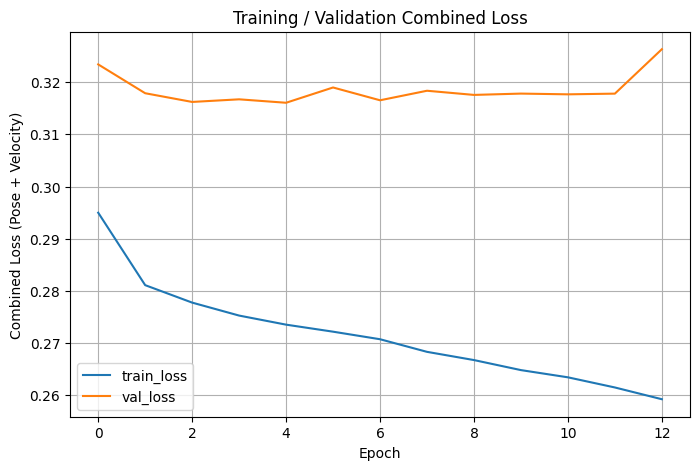

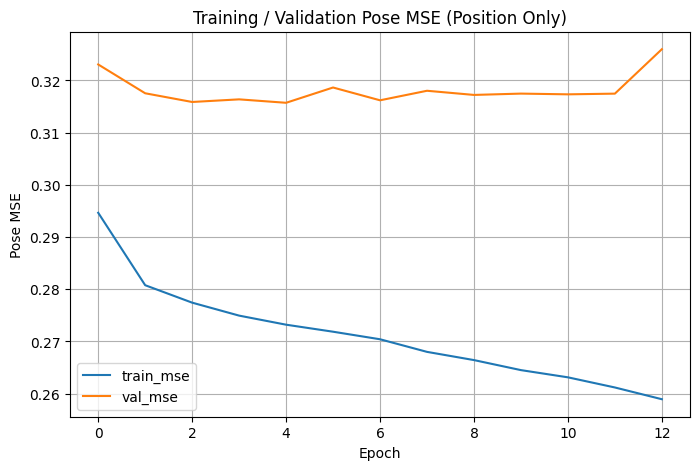

In [ ]:
if not from_scratch:
    if os.path.exists(LOAD_MODEL_PATH):
        print(f"Loading model from: {LOAD_MODEL_PATH}")
        
        model = tf.keras.models.load_model(LOAD_MODEL_PATH,
            custom_objects={'pose_loss_with_vel': pose_loss_with_vel,},
            safe_mode=False
        )
    else:
         raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")
else:
    print("Training from scratch")

tf.config.run_functions_eagerly(False)  # for performance
history = model.fit(
    X_train, Y_train_flat,
    validation_data=(X_test, Y_test_flat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=callbacks_list,
    verbose=1
)
# plot loss curves
# ----------------------------
# 1) Combined loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Combined Loss (Pose + Velocity)')
plt.title('Training / Validation Combined Loss')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 2) Pose-only MSE plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['mse'], label='train_mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('Pose MSE')
plt.title('Training / Validation Pose MSE (Position Only)')
plt.legend()
plt.grid(True)
plt.show()

### Choosing Model for Inference

In [ ]:
if from_scratch:
    print("Using model already in memory (just trained).")
else:
    print(f"\nLoading model from file:\n{LOAD_MODEL_PATH}\n")

    if not os.path.exists(LOAD_MODEL_PATH):
        raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")

    model = tf.keras.models.load_model(LOAD_MODEL_PATH,
        custom_objects={
            'pose_loss_with_vel': pose_loss_with_vel,
        },
        safe_mode=False
    )

    print("Model loaded successfully for inference.")

### Run Example

In [ ]:
sample_idx = 0

motion_id = ids_test[sample_idx]
print("Test motion ID:", motion_id)

# Input embedding
z = X_test[sample_idx:sample_idx+1]   # (1, CAP_DIM)

# Forward pass -> one head: shape (1, T, 66)
pred_flat = model.predict(z)[0]       # remove batch → (T, 66)

# Split flat output → (T, 22, 3)
pred_pose_rel = pred_flat.reshape(MOTION_LEN, NUM_JOINTS, COORDS)

if USE_NORMALIZATION:
    pred_pose_rel = (
        pred_pose_rel * pose_std[0,0,0,:] + pose_mean[0,0,0,:]
    )

# If you want root/world position, integrate velocity?  
# BUT here it's 1-head, so NO root velocity → already absolute?
# In your single-head setup we assume output is WORLD coordinates.
pred_world = pred_pose_rel

print("Predicted motion shape (world coords):", pred_world.shape)


# GT motion (padded)
gt_motion_fixed = pad_or_truncate_motion(
    motions_test[sample_idx], MOTION_LEN
)  # (T, 22, 3)

print("GT motion shape:", gt_motion_fixed.shape)


Test motion ID: 012698
1/1 [==============================] - 0s 310ms/step
Predicted motion final shape: (200, 22, 3)


### Animation of Generated Motion

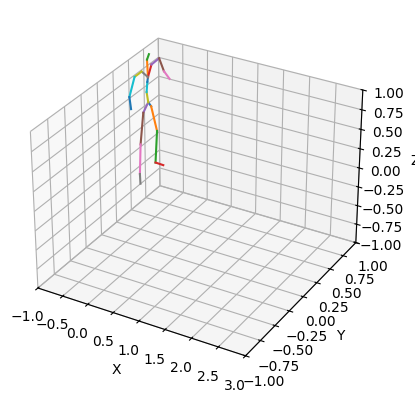

In [ ]:
edges = [
    (0, 1), (1, 4), (4, 7), (7, 10),
    (0, 2), (2, 5), (5, 8), (8, 11),
    (0, 3), (3, 6), (6, 9), (9, 12), (12, 15),
    (9, 13), (13, 16), (16, 18), (18, 20),
    (9, 14), (14, 17), (17, 19), (19, 21),
]

def save_motion_animation(motion, label, motion_id, base_dir):
    """
    motion: (T, 22, 3)
    """
    pose = copy.deepcopy(motion)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Fixed axis (same as your original)
    ax.set(xlim3d=(-1, 3), xlabel='X')
    ax.set(ylim3d=(-1, 1), ylabel='Y')
    ax.set(zlim3d=(-1, 1), zlabel='Z')

    # Lines for edges
    lines = [ax.plot([], [], [])[0] for _ in edges]

    def update_lines(frame_num, pose, lines):
        frame = pose[frame_num]
        for n, (i, j) in enumerate(edges):
            x = [frame[i, 0], frame[j, 0]]
            y = [frame[i, 1], frame[j, 1]]
            z = [frame[i, 2], frame[j, 2]]

            # Preserve your custom orientation (z,x,y)
            lines[n].set_data_3d([z, x, y])
        return lines

    ani = FuncAnimation(
        fig,
        update_lines,
        frames=pose.shape[0],
        fargs=(pose, lines),
        interval=100
    )

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{base_dir}/{label}_{motion_id}_{timestamp}.mp4"
    ani.save(save_path, writer='ffmpeg', fps=30)
    print(f"Saved {label} animation to:", save_path)
    plt.close(fig)

    anim_dir = "/Users/akhidre/pubgit/CS230_T2Motion/animations"

# Save predicted motion
save_motion_animation(pred_world, "generated_GRU_1head", motion_id, anim_dir)

# Save padded GT motion
save_motion_animation(gt_motion_fixed, "gt_fixed", motion_id, anim_dir)

# Save original GT motion
save_motion_animation(gt_motion, "gt_original", motion_id, anim_dir)

### Troubleshoot/Debug

In [ ]:
print(LAMBDA_VEL)


import tensorflow as tf
print("TF GPUs:", tf.config.list_physical_devices('GPU'))

import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

tf.config.experimental.get_visible_devices()
tf.config.list_logical_devices('GPU')

os.path.exists(SAVE_Full_MODEL_PATH)

